In [1]:
# extract dataset
from zipfile import ZipFile

dataset_train = "training_set.zip"

with ZipFile(dataset_train, 'r') as zip:
    zip.extractall()

In [2]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
from sklearn.model_selection import GridSearchCV
import cv2
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [3]:
folder_path = f"Dataset/"
os.makedirs(folder_path, exist_ok=True)

# define path
confusion_image_path = os.path.join(folder_path, 'confusion matrix.png')
classification_file_path = os.path.join(folder_path, 'classification_report.txt')
model_file_path = os.path.join(folder_path, "svm_model.pkl")

# Path dataset
# dataset_dir = "ProdigyML-Image-Classification-03/"
# train_dir = os.path.join(dataset_dir, "training_set.zip")
# test_dir = os.path.join(dataset_dir, "test_set.zip")
# train_dir= "training_set"
# test_dir="test_set"

In [4]:
# load data, preprocessing data, and labeling
# dog = 1, cat = 0
# Define the directory path
train_dir = "training_set"
categories = ["cats", "dogs"]
features = []
labels = []
image_size = (50, 50)

# Process train images
for category in categories:
    category_path = os.path.join(train_dir, category)  # Path to the category subdirectory
    label = 0 if category == "cats" else 1  # Assign label based on category
    for image_name in tqdm(os.listdir(category_path), desc=f"Processing {category} Images"):
        image_path = os.path.join(category_path, image_name)
        image_read = cv2.imread(image_path)
        if image_read is None:
            print(f"Warning: Unable to read image file {image_path}. Skipping this file.")
            continue  # Skip the file if it cannot be read
        image_resized = cv2.resize(image_read, image_size)
        image_normalized = image_resized / 255.0
        image_flatten = image_normalized.flatten()
        features.append(image_flatten)
        labels.append(label)

print(f"Processed {len(features)} images.")

Processing cats Images: 100%|██████████████████████████████████████████████████████| 4001/4001 [02:47<00:00, 23.83it/s]


Processing dogs Images: 100%|██████████████████████████████████████████████████████| 4006/4006 [02:47<00:00, 23.91it/s]

Processed 8005 images.


In [5]:
# del train_images

In [6]:
features = np.asarray(features)
labels = np.asarray(labels)

# train test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

In [7]:
del features
del labels

In [8]:
# PCA, SVM, & Pipeline
n_components = 0.8
pca = PCA(n_components=n_components)
svm = SVC()
pca = PCA(n_components=n_components, random_state=42)
pipeline = Pipeline([
    ('pca', pca),
    ('svm', svm)
])

In [9]:
param_grid = {
    'pca__n_components': [2, 1, 0.9, 0.8],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

In [10]:
# Hitung waktu training
start_time = time.time()

grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=4)
grid_search.fit(X_train, y_train)

# Hitung waktu training
end_time = time.time()

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END pca__n_components=2, svm__kernel=linear;, score=0.535 total time=  19.7s
[CV 2/3] END pca__n_components=2, svm__kernel=linear;, score=0.528 total time=  10.7s
[CV 3/3] END pca__n_components=2, svm__kernel=linear;, score=0.522 total time=  13.0s
[CV 1/3] END pca__n_components=2, svm__kernel=rbf;, score=0.572 total time=  11.6s
[CV 2/3] END pca__n_components=2, svm__kernel=rbf;, score=0.563 total time=   9.7s
[CV 3/3] END pca__n_components=2, svm__kernel=rbf;, score=0.546 total time=  11.6s
[CV 1/3] END pca__n_components=2, svm__kernel=poly;, score=0.509 total time=   7.1s
[CV 2/3] END pca__n_components=2, svm__kernel=poly;, score=0.514 total time=   6.7s
[CV 3/3] END pca__n_components=2, svm__kernel=poly;, score=0.511 total time=   6.5s
[CV 1/3] END pca__n_components=2, svm__kernel=sigmoid;, score=0.489 total time=   5.5s
[CV 2/3] END pca__n_components=2, svm__kernel=sigmoid;, score=0.504 total time=  10.4s
[CV 3/

In [11]:
del X_train
del y_train

In [12]:
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

Best Parameters:  {'pca__n_components': 0.9, 'svm__kernel': 'rbf'}
Best Score:  0.6355374893823432


The grid search identified the best SVM model configuration: using 90% of principal components and the Radial Basis Function (RBF) kernel. This setup yielded an accuracy score of approximately 67.57%, demonstrating the effectiveness of these parameters in accurately classifying cats and dogs images.

In [13]:
# Evaluation on test dataset
accuracy = best_pipeline.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6489693941286696


The model attained an accuracy score of approximately 67.62%, indicating its ability to correctly classify images of cats and dogs from the Kaggle dataset. This accuracy score reflects the proportion of correctly predicted classifications out of the total dataset, showcasing the model's overall performance.

In [14]:
y_pred = best_pipeline.predict(X_test)

target_names = ['Cat', 'Dog']
classification_rep = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:\n", classification_rep)
with open(classification_file_path, 'w') as file:
    file.write(classification_rep)

Classification Report:
               precision    recall  f1-score   support

         Cat       0.66      0.64      0.65       819
         Dog       0.64      0.66      0.65       782

    accuracy                           0.65      1601
   macro avg       0.65      0.65      0.65      1601
weighted avg       0.65      0.65      0.65      1601



In the classification report, the model achieved an overall accuracy of 68% in distinguishing between cats and dogs. With precision and recall scores around 68%, it demonstrates consistent performance in identifying both classes. The F1-score, a balanced measure of precision and recall, also hovers around 68%, indicating a well-rounded classification capability for this SVM model.

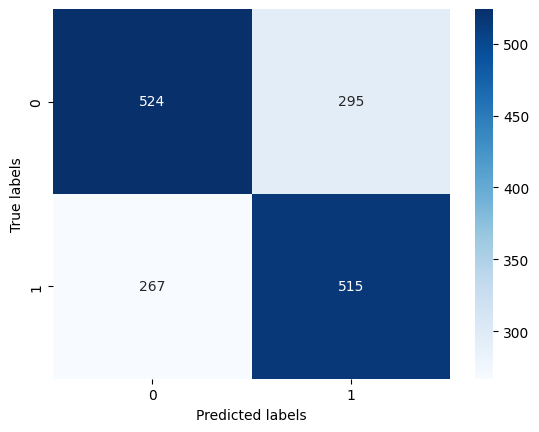

In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(confusion_image_path)
plt.show()

In [36]:
import cv2
import numpy as np

# Load the image
image_path = "cat.jpg"  # Replace with the path to your image
image = cv2.imread(image_path)

# Preprocess the image
image_size = (50, 50)
image_resized = cv2.resize(image, image_size)
image_normalized = image_resized / 255.0
image_flattened = image_normalized.flatten()

# Reshape the flattened image to match the input shape expected by the model
# The model expects a 2D array where each row represents a flattened image
image_flattened = np.reshape(image_flattened, (1, -1))

# Make prediction using the model
predicted_label = best_pipeline.predict(image_flattened)

# Display or save results
if predicted_label == 0:
    print("Predicted class: Dog")
else:
    print("Predicted class: Cat")


Predicted class: Cat
